In [1]:
# =============================================================================
#
# Pronositco usando un MLP con la serie sin diferenciar y sin escalar
#
# =============================================================================
"""import warnings

warnings.filterwarnings("ignore")

#
# Carga de datos
#
import nbimporter  #  type: ignore
import functions  #  type: ignore


df_orig = functions.load_data()
df_orig.head()"""

'import warnings\n\nwarnings.filterwarnings("ignore")\n\n#\n# Carga de datos\n#\nimport nbimporter  #  type: ignore\nimport functions  #  type: ignore\n\n\ndf_orig = functions.load_data()\ndf_orig.head()'

In [1]:
# =============================================================================
#
# Pronostico time trend + dummy seasonal
#
# =============================================================================

#
# Carga de datos
#
import importlib.util
import sys
import nbformat
from nbconvert import PythonExporter

def import_notebook(nb_path):
    with open(nb_path, "r", encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=4)

    exporter = PythonExporter()
    source, _ = exporter.from_notebook_node(nb)

    module_name = nb_path.replace(".ipynb", "").replace("/", "_")
    spec = importlib.util.spec_from_loader(module_name, loader=None)
    module = importlib.util.module_from_spec(spec)
    exec(source, module.__dict__)
    sys.modules[module_name] = module

    return module

functions = import_notebook("../homework/functions.ipynb")

# Now try calling your function
df_orig = functions.load_data()
df_orig.head()

,yt_true
date,
1946-01-01,890
1946-02-01,992
1946-03-01,979
1946-04-01,959
1946-05-01,1110


In [2]:
#
# Construcción de la matriz de regresores
#

df_orig = functions.make_lagged_ts(
    df=df_orig,
    p_max=13,
    y_column="yt_true",
    fmt="lagged_{}m",
)
df_orig.head()

,yt_true,lagged_1m,lagged_2m,lagged_3m,lagged_4m,lagged_5m,lagged_6m,lagged_7m,lagged_8m,lagged_9m,lagged_10m,lagged_11m,lagged_12m,lagged_13m
date,,,,,,,,,,,,,,
1946-01-01,890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-02-01,992,890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-03-01,979,992.0,890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-04-01,959,979.0,992.0,890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-05-01,1110,959.0,979.0,992.0,890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#
# Remoción de los valores faltantes
#
df_dropna = df_orig.dropna()

In [4]:
#
# División de los datos en entrenamiento y prueba
#
(
      X_complete,
      y_complete,
      X_train,
      y_train,
      X_test,
      y_test,
) = functions.train_test_split(
      df=df_dropna,
      x_columns=[f"lagged_{i}m" for i in range(1, 13)],
      y_column="yt_true",
)

In [5]:
#
# Pronostico usando una red neuronal tipo MLP
#
from sklearn.pipeline import Pipeline  #  type: ignore
from sklearn.preprocessing import MinMaxScaler  #  type: ignore
from sklearn.compose import TransformedTargetRegressor  #  type: ignore
from sklearn.neural_network import MLPRegressor  #  type: ignore


# Crea un pipeline para automatizar la creacion de un modelo
def make_pipeline_from_model(model):
    """Create a pipeline."""
    return Pipeline(
        [
            (
                "scaler",
                MinMaxScaler(),
            ),
            (
                "regressor",
                TransformedTargetRegressor(
                    regressor=model,
                    transformer=MinMaxScaler(),
                ),
            ),
        ]
    )

In [6]:
#
# Entrenamiento y pronostico
#
hidden = 8
mlp_model = MLPRegressor(
    hidden_layer_sizes=(hidden,),
    activation="logistic",
    learning_rate="adaptive",
    momentum=0.01,
    learning_rate_init=0.2,
    max_iter=10000,
    random_state=123456,
)
mlp_pipeline = make_pipeline_from_model(model=mlp_model)
mlp_pipeline.fit(X_train, y_train)

df_dropna[f"yt_pred_mlp_{hidden}"] = mlp_pipeline.predict(X_complete)
df_dropna[["yt_true", f"yt_pred_mlp_{hidden}"]].head()

C:\Users\Alejandro Feria\AppData\Local\Temp\ipykernel_7580\668155829.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna[f"yt_pred_mlp_{hidden}"] = mlp_pipeline.predict(X_complete)


,yt_true,yt_pred_mlp_8
date,,
1947-02-01,1517,1260.828758
1947-03-01,1707,1360.020367
1947-04-01,1729,1434.927683
1947-05-01,1788,1488.115980
1947-06-01,2008,1665.903380


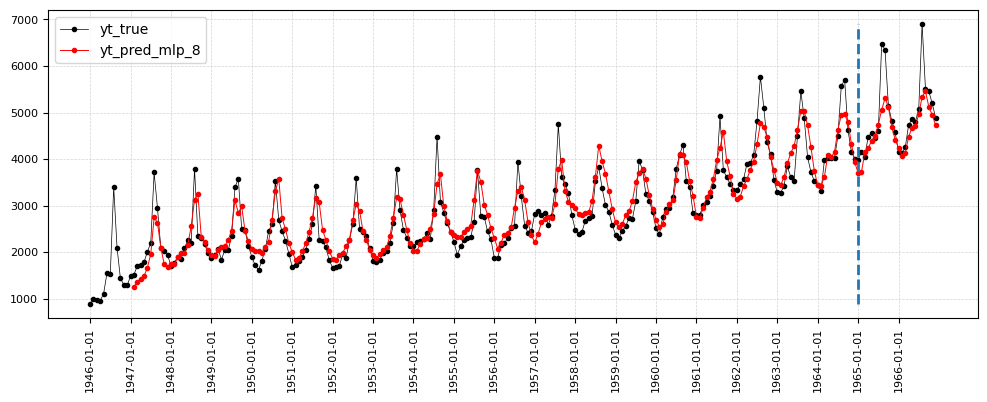

In [7]:
#
# Gráfica de los pronósticos
#
df_orig.loc[df_dropna.index, f"yt_pred_mlp_{hidden}"] = df_dropna[
    f"yt_pred_mlp_{hidden}"
]

functions.plot_time_series(df=df_orig, yt_col="yt_true")

In [8]:
#
# Almacenamiento de los resultados
#
functions.save_forecasts(df_orig)

In [ ]:
#
# Métricas de error
#
metrics = functions.compute_evaluation_metrics(df_orig.dropna())
functions.save_metrics(metrics)
metrics

,Metrics,yt_pred_mlp_8
0,MSE Train,109154.28
1,MSE Test,263190.52
2,MAE Train,248.99
3,MAE Test,309.45
